# Figure - depth resolution

In [1]:
import os
work_dir = "H:/workspace/ptyrad_paper"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad_paper


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy import ndimage

## Load reconstructed object

In [3]:
folder_path = "03_output/tBL_WSe2/20250319_ptyrad_depth_res/full_N16384_dp128_flipT100_random16_p12_1obj_20slice_dz1_Adam_ps20_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_orblur0.4_ozblur1_mamp0.03_4_oathr0.98_oposc_sng1.0_spr0.1_aff1_0_-3_0/"
ckpt_path   = os.path.join(folder_path, "model_iter1000.pt")
ckpt        = torch.load(ckpt_path, weights_only=False)

In [4]:
# Crop the edges of the object canvas
crop_pos     = ckpt['model_attributes']['crop_pos'].cpu().numpy() + np.array(ckpt['optimizable_tensors']['probe'].shape[-2:])//2
y_min, y_max = crop_pos[:,0].min(), crop_pos[:,0].max()
x_min, x_max = crop_pos[:,1].min(), crop_pos[:,1].max()
obj_raw      = ckpt['optimizable_tensors']['objp'].cpu().numpy().squeeze()[:, y_min:y_max, x_min:x_max]


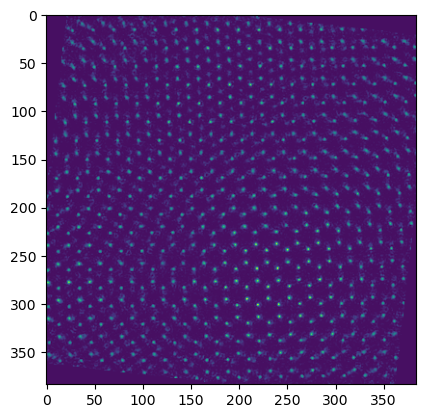

In [5]:
# Rotate the object image
obj          = ndimage.rotate(obj_raw, -6.6, axes=(1, 2), reshape=False)
plt.figure()
plt.imshow(obj[9])
plt.show()

## Top view panel

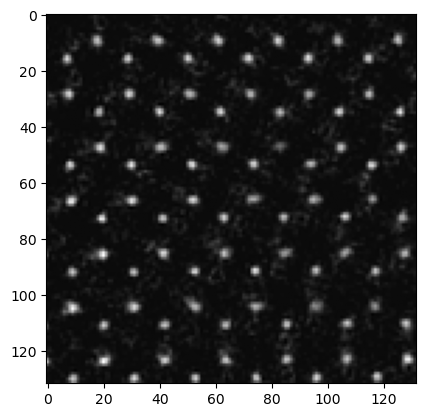

In [6]:
window_roi = (154,25,286,157) # y_min,x_min,y_max,x_max
window = obj[:, window_roi[0]:window_roi[2], window_roi[1]:window_roi[3]]
plt.figure()
plt.imshow(window[8], cmap='gray')
plt.show()

In [7]:
# from tifffile import imwrite
# imwrite('window.tif', np.float32(window))

## Line profile fitting panel

In [8]:
W_coords = np.array([
    [16,7],[16,29],[16,51],[16,72],[16,94],[16,115],
    [35,19],[35,40],[35,62],[35,83],[35,104],[35,126],
    [54,8],[54,30],[54,52],[54,74],[54,94],[54,116],
    [73,20],[73,41],[73,63],[73,85],[73,106],[73,127],
    [92,9],[92,31],[92,53],[92,74],[92,96],[92,117],
    [111,20],[111,42],[111,64],[111,86],[111,107],[111,128],
    [130,9],[130,31],[130,53],[130,75],[130,96],[130,118]
])

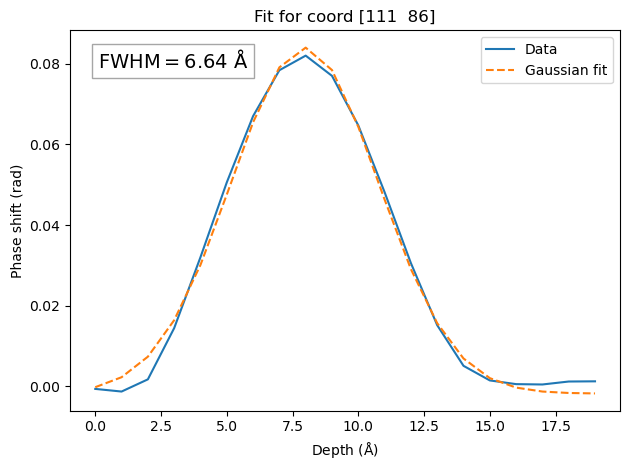

In [9]:
from scipy.optimize import curve_fit

def gaussian_1D(x, A, mu, sigma, offset):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + offset

lines = []
fit_params = []

x = np.arange(len(window))  # number of slices

for coord in W_coords:
    line = window[:, coord[0], coord[1]]

    # Initial guess for [A, mu, sigma, offset]
    A_guess = np.max(line) - np.min(line)
    mu_guess = np.argmax(line)
    sigma_guess = len(line) / 10
    offset_guess = np.min(line)
    p0 = [A_guess, mu_guess, sigma_guess, offset_guess]

    try:
        popt, _ = curve_fit(gaussian_1D, x, line, p0=p0)
        fit_params.append(popt)
        sigma = popt[2]
        
        # Plot original line and fitted Gaussian
        if (coord == np.array([111,86])).all():
            plt.figure()
            plt.plot(x, line, label="Data")
            plt.plot(x, gaussian_1D(x, *popt), label="Gaussian fit", linestyle="--")
            
            # Add sigma as a text label on the plot
            plt.text(0.05, 0.95, f"$\\mathrm{{FWHM}} = {sigma*2.355:.2f}\\ \\mathrm{{\\AA}}$",
                    transform=plt.gca().transAxes,
                    verticalalignment='top', fontsize=14, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

            plt.legend()
            plt.title(f"Fit for coord {coord}")
            plt.xlabel("Depth ($\\mathrm{\\AA}$)")
            plt.ylabel("Phase shift (rad)")
            plt.tight_layout()
            plt.show()

    except RuntimeError:
        print(f"Fit failed for coord {coord}")
        fit_params.append(None)

fit_params = np.array(fit_params)

In [10]:
fit_params[fit_params[:,2]<3.6,2] # std in Ang

array([3.25700122, 3.03231305, 3.08820525, 3.40366506, 3.27822783,
       3.24152749, 3.25058941, 3.0345994 , 3.15989863, 2.84877415,
       2.8843244 , 3.27637231, 3.11890475, 3.2842862 , 3.11423805,
       3.04561196, 3.19063854, 3.3369051 , 3.28900719, 3.35122057,
       3.18690962, 3.21587492, 3.44281761, 3.28828521, 3.25094893,
       3.0180486 , 3.1664253 , 2.93112587, 2.8205079 , 3.4488411 ,
       3.09651758, 3.01026043, 3.17886799, 3.14459159])

In [11]:
fit_params[fit_params[:,2]<3.6,2] * 2.355 # FWHM in Ang

array([7.67023787, 7.14109723, 7.27272337, 8.01563122, 7.72022654,
       7.63379724, 7.65513806, 7.14648158, 7.44156127, 6.70886312,
       6.79258395, 7.71585679, 7.34502069, 7.73449399, 7.3340306 ,
       7.17241617, 7.51395376, 7.85841151, 7.74561194, 7.89212443,
       7.50517216, 7.57338543, 8.10783548, 7.74391168, 7.65598472,
       7.10750446, 7.45693158, 6.90280143, 6.64229611, 8.12202078,
       7.2922989 , 7.0891633 , 7.4862341 , 7.4055132 ])

In [12]:
np.min(fit_params[fit_params[:,2]<3.6,2] * 2.355) # FWHM in Ang

np.float64(6.642296113340558)

## Histogram of atom depth panel

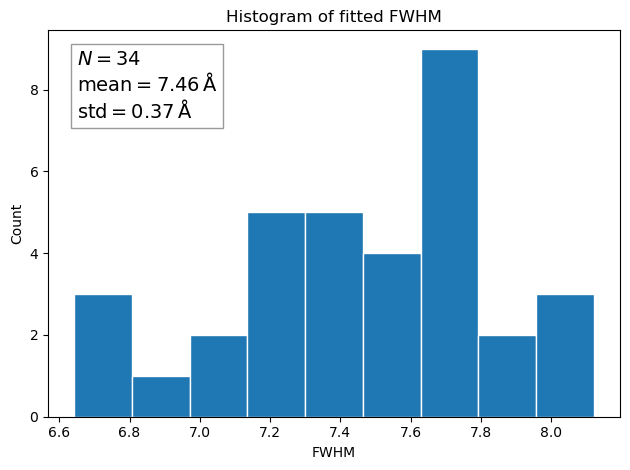

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Convert fit_params to a NumPy array if it's not already
fit_params = np.array(fit_params)

# Select sigma values (index 2) with a condition
FWHMs = fit_params[fit_params[:, 2] < 3.6, 2] * 2.355  # Convert to FWHM in Ang

# Compute statistics
mean_val = np.mean(FWHMs)
std_val = np.std(FWHMs)
N = len(FWHMs)

# Plot histogram
plt.figure()
plt.hist(FWHMs, bins=9, color='C0', edgecolor='white')

# Add text box with stats
textstr = '\n'.join((
    r'$N = %d$' % N,
    r'$\mathrm{mean} = %.2f\,\mathrm{\AA}$' % mean_val,
    r'$\mathrm{std} = %.2f\,\mathrm{\AA}$' % std_val,
))
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='left',
         fontsize=14, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.xlabel("FWHM")
plt.ylabel("Count")
plt.title("Histogram of fitted FWHM")
plt.tight_layout()
plt.show()


# Cross-sectional view panel

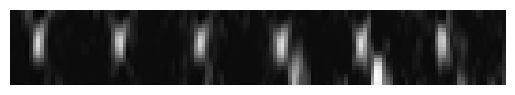

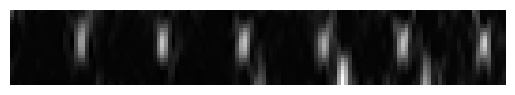

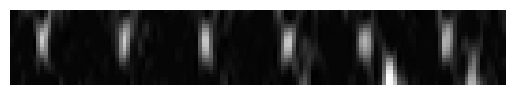

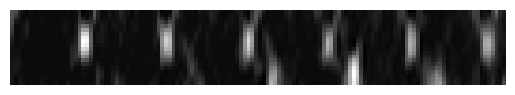

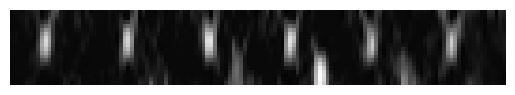

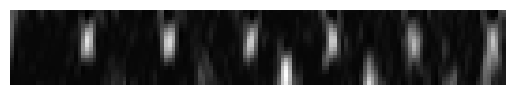

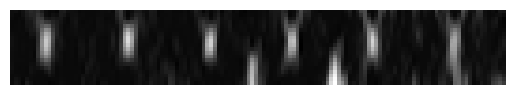

In [14]:
selected_rows = [16,35,53,73,92,111,130]
for row in selected_rows:
    cross_view = window[:,row]
    plt.figure()
    plt.imshow(cross_view, cmap='gray')
    plt.axis('off')
    plt.show()

## Final figure

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.patches as patches

# Create the figure with improved flexible layout
def create_improved_layout(figsize=(10, 8), dpi=600, width_ratio=1, height_ratios=None):
    """
    Create a flexible layout with better alignment control
    
    Parameters:
    - figsize: figure size in inches
    - width_ratio: ratio of left column width to right column width
    - height_ratios: list of lists, each sublist contains height ratios for each column
    """
    if height_ratios is None:
        height_ratios = [[3, 1], [1, 1]]
        
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    # Create the outer grid: 1 row, 2 columns
    outer_grid = GridSpec(1, 2, figure=fig, width_ratios=[width_ratio, 1], wspace=0.3)
    
    # Create nested GridSpecs for each column
    left_column = GridSpecFromSubplotSpec(
        2, 1, 
        subplot_spec=outer_grid[0, 0], 
        height_ratios=height_ratios[0],
        hspace=0.1
    )
    
    right_column = GridSpecFromSubplotSpec(
        2, 1, 
        subplot_spec=outer_grid[0, 1], 
        height_ratios=height_ratios[1],
        hspace=0.3
    )
    
    # Create the axes
    ax1 = fig.add_subplot(left_column[0])   # Top left
    ax2 = fig.add_subplot(left_column[1])   # Bottom left
    ax3 = fig.add_subplot(right_column[0])  # Top right
    ax4 = fig.add_subplot(right_column[1])  # Bottom right
    
    return fig, (ax1, ax2, ax3, ax4)

In [16]:
# Prepare figure data
selected_coord = [111,86]

# Plane view
img_plane_view = window[8]

# Cross-sectional view
cross_view = window[:,selected_coord[0]]

# Histogram
lines = []
fit_params = []
sigmas = []
selected_line_profile = []

x = np.arange(len(window))  # number of slices

for coord in W_coords:
    line = window[:, coord[0], coord[1]]

    # Initial guess for [A, mu, sigma, offset]
    A_guess = np.max(line) - np.min(line)
    mu_guess = np.argmax(line)
    sigma_guess = len(line) / 10
    offset_guess = np.min(line)
    p0 = [A_guess, mu_guess, sigma_guess, offset_guess]

    popt, _ = curve_fit(gaussian_1D, x, line, p0=p0)
    fit_params.append(popt)
    sigmas.append(popt[2])
    if all(coord == np.array(selected_coord)):
        selected_line_profile.append([line, popt])

FWHMs = np.array(sigmas)*2.355 # For Gaussian, FWHM ~ 2.355*sigma
FWHMs = FWHMs[FWHMs<8.478] # FWHM in Ang. Fitted FWHM > 9 Ang is probably a bad fit or got disrupted by other layer

# Line profile 
line_profile = selected_line_profile[0][0]
popt = selected_line_profile[0][1]

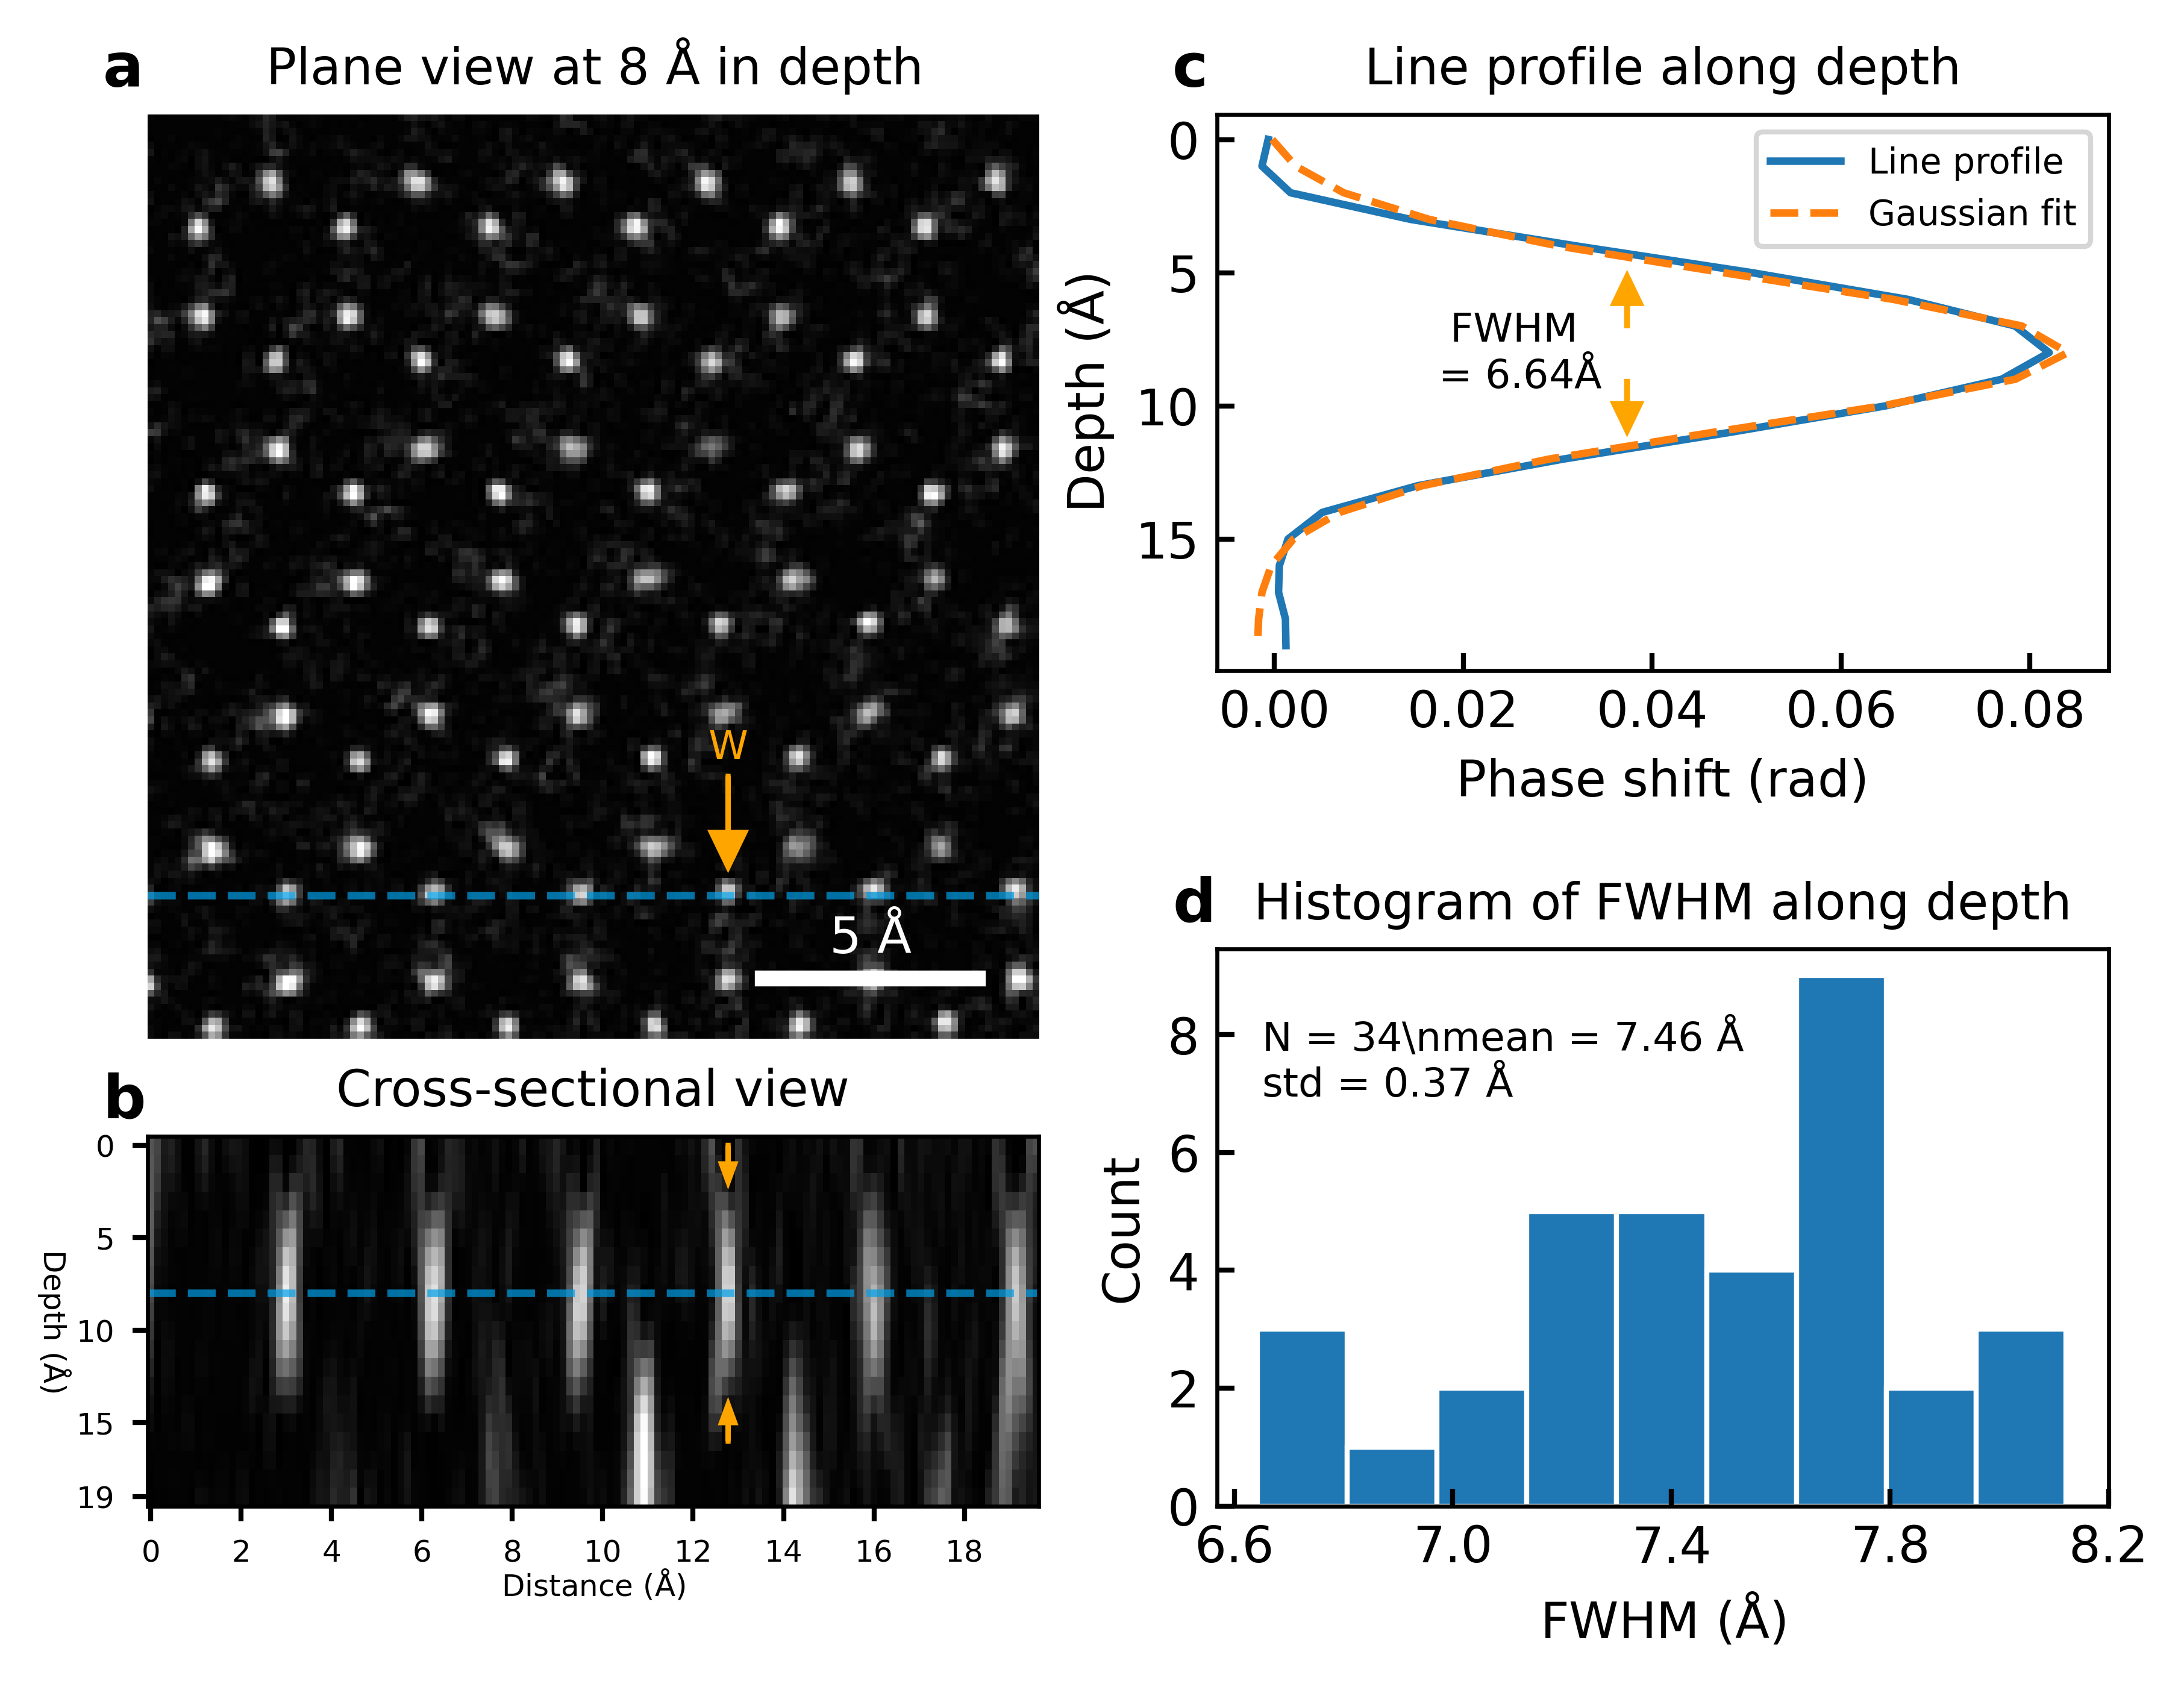

In [17]:
import matplotlib as mpl
import matplotlib.ticker as tck
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

mpl.rc('xtick', direction='in')
mpl.rc('xtick.major', width=1, size=3.5)
mpl.rc('xtick.minor', width=1, size=2)
mpl.rc('ytick', direction='in')
mpl.rc('ytick.major', width=1, size=3.5)
mpl.rc('ytick.minor', width=1, size=2)

# Create the layout with custom ratios
fig = plt.figure(figsize=(7,5), dpi=600)
    
# Create the outer grid: 1 row, 2 columns
outer_grid = GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.2)

# Create nested GridSpecs for each column
left_column = GridSpecFromSubplotSpec(
    2, 1, 
    subplot_spec=outer_grid[0, 0], 
    height_ratios=[2.5,1],
    hspace=0.15
)

right_column = GridSpecFromSubplotSpec(
    2, 1, 
    subplot_spec=outer_grid[0, 1], 
    height_ratios=[1,1],
    hspace=0.5
)

# Some constants
fontsize_title = 10
panel_labels = ['a', 'b', 'c', 'd']
shadow_offset =  (0.01,0.01)

# Create the axes
ax1 = fig.add_subplot(left_column[0])   # Top left
ax2 = fig.add_subplot(left_column[1])   # Bottom left
ax3 = fig.add_subplot(right_column[0])  # Top right
ax4 = fig.add_subplot(right_column[1])  # Bottom right

# Plot data in each panel
# Panel 1: Spots image with arrow and line
vmin, vmax = np.percentile(img_plane_view, [1, 99.9])
ax1.imshow(img_plane_view, cmap='gray', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
y_line = selected_coord[0]
ax1.axhline(y=y_line, color='#00A0E9', linestyle='--', alpha=0.7)
arrow_x, arrow_y = selected_coord[1], selected_coord[0]-17
ax1.arrow(arrow_x-0.5, arrow_y, 0, 8, head_width=5, head_length=5, fc='orange', ec='orange')
ax1.axis('off')
ax1.set_title('Plane view at 8 $\\mathrm{\\AA}$ in depth', fontsize=fontsize_title)
ax1.text(arrow_x-0.5, arrow_y-4, 'W', color='orange',
         transform=ax1.transData,
         ha='center', va='center', fontsize=8)

# Scale bar settings
scale_bar_length = 5/0.1494  # Length of the scale bar in pixels (1 px = 0.1494 Ang)
scale_bar_label = "5 $\\mathrm{\\AA}$"  # Label for the scale bar
scale_bar_color = "white"
fontprops = fm.FontProperties(size=10)

# Panel 2: Cross-sectional view
vmin, vmax = np.percentile(cross_view, [1, 99.9])
ax2.imshow(cross_view, cmap='gray', aspect='auto', origin='upper', vmin=vmin, vmax=vmax)
ax2.set_title('Cross-sectional view', fontsize=fontsize_title)
ax2.axhline(y=8, color='#00A0E9', linestyle='--', alpha=0.7)

ax2.axis('on')
ax2.yaxis.set_ticks_position('left')
ax2.yaxis.set_label_position('left')
ax2.set_yticks(ticks=[0,5,10,15,19])
ax2.set_ylabel('Depth ($\\mathrm{\\AA}$)', fontsize=6, rotation=-90, labelpad=8)
ax2.tick_params(axis='y', which='both', labelsize=6, direction='out', length=3)  # Adjust label size if needed

# Set x-ticks every 2 Å
px_size = 0.1494  # Angstroms per pixel
num_cols = cross_view.shape[-1]  # Number of columns in cross-sectional view
max_distance = num_cols * px_size  # Maximum distance in Angstroms

# Create tick positions at every 2 Å
x_labels = np.arange(0, max_distance, 2)
x_positions = x_labels / px_size  # Convert Angstroms back to pixel units

ax2.set_xticks(ticks=x_positions)
ax2.set_xticklabels([f"{x:.0f}" for x in x_labels])  # Round labels to integers
ax2.set_xlabel('Distance ($\\mathrm{\\AA}$)', fontsize=6, labelpad=0)
ax2.tick_params(axis='x', which='both', labelsize=6, direction='out', length=3)
# Add the arrows
ax2.arrow(selected_coord[1]-0.5, 8+8, 0, -1, transform=ax2.transData, head_width=2, head_length=1, fc='orange', ec='orange')
ax2.arrow(selected_coord[1]-0.5, 8-8, 0,  1, transform=ax2.transData, head_width=2, head_length=1, fc='orange', ec='orange')


# Panel 3: Phase shift plot
ax3.plot(line_profile, x, label='Line profile')
ax3.plot(gaussian_1D(x, *popt), x, linestyle='--', label='Gaussian fit')
arrow_x, arrow_y = 0.46, 0.57
ax3.arrow(arrow_x, arrow_y+0.05, 0, 0.04, transform=ax3.transAxes, head_width=0.03, head_length=0.05, fc='orange', ec='orange')
ax3.arrow(arrow_x, arrow_y-0.05, 0, -0.04, transform=ax3.transAxes, head_width=0.03, head_length=0.05, fc='orange', ec='orange')
ax3.invert_yaxis()
ax3.set_xlabel('Phase shift (rad)')
ax3.set_ylabel('Depth ($\\mathrm{{\\AA}}$)')
ax3.legend(loc='upper right', fontsize=7)
ax3.set_title('Line profile along depth', fontsize=fontsize_title)
ax3.text(arrow_x-0.12, arrow_y, f'FWHM \n= {popt[2]*2.355:.2f}$\\mathrm{{\\AA}}$', 
         transform=ax3.transAxes,
         ha='center', va='center', fontsize=8)

# Panel 4: Histogram
counts, bins, _ = ax4.hist(FWHMs, bins=9, color='C0', edgecolor='white')
ax4.set_xlabel('FWHM ($\\mathrm{{\\AA}}$)')
ax4.set_ylabel('Count')
ax4.set_title('Histogram of FWHM along depth', fontsize=fontsize_title)

N = len(FWHMs)
mean = np.mean(FWHMs)
std = np.std(FWHMs)
stats_text = f"N = {N}\\nmean = {mean:.2f} $\\mathrm{{\\AA}}$\nstd = {std:.2f} $\\mathrm{{\\AA}}$"
ax4.text(0.05, 0.8, stats_text, 
        transform=ax4.transAxes,
        ha='left', va='center', fontsize=8)
ax4.set_xticks(ticks=np.linspace(6.6,8.2,5))

# Add scale bar
scalebar = AnchoredSizeBar(ax1.transData, scale_bar_length, label=scale_bar_label,
                        loc='lower right', pad=1, sep=2, color=scale_bar_color, frameon=False, size_vertical=1.5, label_top=True,
                        fontproperties=fontprops)
ax1.add_artist(scalebar)

# Add panel label
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    if i ==0:
        ax.text(-0.05, 1.03, panel_labels[i], transform=ax.transAxes, color='black', fontsize=12, fontweight='bold')
    else:       
        ax.text(-0.05, 1.05, panel_labels[i], transform=ax.transAxes, color='black', fontsize=12, fontweight='bold')

plt.savefig("05_figures/Fig_S12_depth_resolution.pdf", bbox_inches="tight")
plt.savefig("05_figures/Fig_S12_depth_resolution.png", bbox_inches="tight")

plt.show()